In [1]:
import numpy as np
import matplotlib.pyplot as plt

Initial value of the plasma parameters :
* $\rho_0$ the upstream charge density : `n0`
* $B_0$ the upstream modulus of the magnetic field : `B0`
* $\beta_0$ the upstream plasma parameter : `beta0`
* $\Theta_0$ the angle between the upstream magnetic field and the normal to the shock : `theta0`

In [2]:
n0 = 1.0
B0 = 1.0
beta0 = 0.8
theta0 = 30*np.pi/180.0

We use `n` and `T` index notation for normal and tangential, respectively. Following the definition of `theta`

In [3]:
B0_n = np.cos(theta0)
B0_T = np.sin(theta0)

From the definition of the $\beta$ parameter :

In [4]:
p0 = 0.5*beta0*B0**2

We then have as unknown : `n0`, `n1`, `v0_n`, `v0_T`, `v1_n`, `v1_T`, `p0`, `p1`, `B0_n` `B0_T`, `B1_n`, `B1_T`, that is 12 unknowns.
We already know as parameter : `n0`, `p0`, `B0_n` and `B0_T`. Furthermore, we are going to iterate on the normal valocity value. It could be on side 0 or side 1. We then know 5 initial velues so we need 7 equations for the 7 remaining unknowns.

**Maxwell-Thomson** : 1 equation

In [5]:
# B0_n-B1_n = 0

**Maxwell-Faraday** (tangential) : 1 equation

In [6]:
# v0_n*B0_T-B0_n*v0_T-(v1_n*B1_T-B1_n*v1_T) = 0

**de Hoffmann-Teller frame** : 1 equation for each side, that is total of 2 equations. As a consequence, Maxwell-Faraday will automatically be satisfied and is no more needed.

In [7]:
# v0_n*B0_T-B0_n*v0_T = 0
# v1_n*B1_T-B1_n*v1_T = 0

**Mass conservation** : 1 equation

In [8]:
# n0*v0_n-n1*v1_n = 0

**Momentum conservation** : 2 equations

In [9]:
# n0*v0_n**2+p0+0.5*(B0_T**2-B0_n**2)-(n1*v1_n**2+p1+0.5*(B1_T**2-B1_n**2)) = 0
# n0*v0_n*v0_T-B0_n*B0_T-(n1*v1_n*v1_T-B1_n*B1_T) = 0

**Energy conservation** : 1 equation

In [10]:
# 0.5*n0*(v0_n**2+v0_T**2)*v0_n+2.5*p0*v0_n-B0_T*(B0_n*v0_T-B0_T*v0_n)-(0.5*n1*(v1_n**2+v1_T**2)*v1_n+2.5*p1*v1_n-B1_T*(B1_n*v1_T-B1_T*v1_n)) = 0

Using the Maxwell-Faraday and the HT frame, energy conservation can be simplified as

In [11]:
# n0*v0_n*v0**2+5*p0*v0_n-(n1*v1_n*v1**2+5*p0*v1_n) = 0

First, let see if we can find all the solution if iterating on the possible `v0_n` values. With the preceding 7 equations, one can analytically pre-compute `v0_T` and `B1_n`.

In [12]:
def compute0(v0_n, B0_n, B0_T):
    # return the values of v0_T, B1_n
    return v0_n*B0_T/B0_n, B0_n

We then define the cost function which depends on the 5 components vectors :
`x = (n1, v1_n, v1_T, p1, B1_T)`
with the `args` vector defined as `args = (n0,  v0_n, v0_T, p0, B0_n, B0_T, B1_n)`.

In [13]:
def cost0(x, *args):
    n1, v1_n, v1_T, p1, B1_T = x
    n0, v0_n, v0_T, p0, B0_n, B0_T, B1_n = args
    
    return [
            n0*v0_n-n1*v1_n,
            n0*v0_n**2+p0+0.5*B0_T**2-(n1*v1_n**2+p1+0.5*B1_T**2),
            n0*v0_n*v0_T-B0_n*B0_T-(n1*v1_n*v1_T-B1_n*B1_T),
            n0*v0_n*(v0_n**2+v0_T**2)+5*p0*v0_n-(n1*v1_n*(v1_n**2+v1_T**2)+5*p1*v1_n),
            v1_n*B1_T-B1_n*v1_T
           ]

We are also going to define a cost function `cost1` when iterating on `v1_n` (and the associated compute function `compute1`) because it could be of interest for some given branch of the solution. 

In [14]:
def compute1(B0_n):
    # return the values of B1_n
    return B0_n

In [15]:
def cost1(x, *args):
    n1, v0_n, v0_T, v1_T, p1, B1_T = x
    n0, v1_n, p0, B0_n, B0_T, B1_n = args
    
    return [
            n0*v0_n-n1*v1_n,
            n0*v0_n**2+p0+0.5*B0_T**2-(n1*v1_n**2+p1+0.5*B1_T**2),
            n0*v0_n*v0_T-B0_n*B0_T-(n1*v1_n*v1_T-B1_n*B1_T),
            n0*v0_n*(v0_n**2+v0_T**2)+5*p0*v0_n-(n1*v1_n*(v1_n**2+v1_T**2)+5*p1*v1_n),
            v0_n*B0_T-B0_n*v0_T,
            v1_n*B1_T-B1_n*v1_T
           ]

In [16]:
gamma = 5./3.

# ___ magnetic field :
B0 = np.sqrt(B0_n**2+B0_T**2)

# ___ intermediate velocity :
v0_i = B0_n/np.sqrt(n0)

# ___ Alfven velocity :
v0_A = B0/np.sqrt(n0)

# ___ sound speed :
c0_s = np.sqrt(gamma*p0/n0)

# ___ slow mode :
v0_s = np.sqrt(0.5*(v0_A**2+c0_s**2-np.sqrt((v0_A**2+c0_s**2)**2-4.0*v0_A**2*c0_s**2*(np.cos(theta0))**2)))

# ___ fast mode :
v0_f = np.sqrt(0.5*(v0_A**2+c0_s**2+np.sqrt((v0_A**2+c0_s**2)**2-4.0*v0_A**2*c0_s**2*(np.cos(theta0))**2)))

In [17]:
print("upstream sound speed            : %5.2f" % c0_s)
print("upstream Alfven velocity        : %5.2f" % v0_A)
print("upstream intermediate velocity  : %5.2f" % v0_i)
print("upstream slow velocity          : %5.2f" % v0_s)
print("upstream fast velocity          : %5.2f" % v0_f)

upstream sound speed            :  0.82
upstream Alfven velocity        :  1.00
upstream intermediate velocity  :  0.87
upstream slow velocity          :  0.63
upstream fast velocity          :  1.13


In [18]:
from scipy.optimize import least_squares

**Non-physical** branch : normal velocity is increasing through the shock

In [19]:
v0_n_span_A = np.linspace(0.3, v0_s, 100)
v1_n_span_A = np.zeros_like(v0_n_span_A)

#       n1,  v1_n,  v1_T,    p1,  B1_T
x0 = (1.01,  1.62,  0.35,  0.41,  0.49)

for i, v0_n in enumerate(v0_n_span_A):
    v0_T, B1_n = compute0(v0_n, B0_n, B0_T)
    args=(n0, v0_n, v0_T, p0, B0_n, B0_T, B1_n)
    sol = least_squares(cost0, x0, args=args, bounds=([0, np.inf]), method='trf')
    n1, v1_n, v1_T, p1, B1_T = sol.x
    v1_n_span_A[i] = v1_n
    x0 = sol.x

**Slow shock** branch : the upstream normal velocity is larger than the slow magnetosonic mode

In [20]:
v0_n_span_B = np.linspace(0.635, v0_i, 100)
v1_n_span_B = np.zeros_like(v0_n_span_B)

#       n1,  v1_n,  v1_T,    p1,  B1_T
x0 = (1.00,  0.63,  0.36,  0.41,  0.49)

for i, v0_n in enumerate(v0_n_span_B):
    v0_T, B1_n = compute0(v0_n, B0_n, B0_T)
    args=(n0, v0_n, v0_T, p0, B0_n, B0_T, B1_n)
    sol = least_squares(cost0, x0, args=args, bounds=([0, np.inf]), method='trf')
    n1, v1_n, v1_T, p1, B1_T = sol.x
    v1_n_span_B[i] = v1_n
    x0 = sol.x
# print(x0)
# print(v0_T, B1_n)
# print(args)

**Intermediate shock** branch : the upstream normal velocity is larger than the intermediate velocity

In [22]:
v1_n_span_C = np.linspace(0.61, v0_i, 100)
v0_n_span_C = np.zeros_like(v1_n_span_C)

#       n1,  v0_n, v0_T, v1_T,   p1, B1_T
x0 = (1.42,  0.87, 0.50, 0.00, 0.74, 0.00)

for i, v1_n in enumerate(v1_n_span_C):
    B1_n = compute1(B0_n)
    args=(n0, v1_n, p0, B0_n, B0_T, B1_n)
    sol = least_squares(cost1, x0, args=args, bounds=([(0, 0, 0, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, 0, np.inf, 0)]))
    n1, v0_n, v0_T, v1_T, p1, B1_T = sol.x
    v0_n_span_C[i] = v0_n
    x0 = sol.x
# print(x0)
# print(args)
# (v0_n_span_C.max())

**Non-physical** branch : normal velocity is increasing through the shock

In [23]:
v1_n_span_D = np.linspace(0.87, 1.23, 100)
v0_n_span_D = np.zeros_like(v1_n_span_D)

#       n1,  v0_n,  v0_T,  v1_T,   p1,  B1_T
x0 = (1.00,  0.87,  0.50, -0.50,  0.40, -0.50)

for i, v1_n in enumerate(v1_n_span_D):
    B1_n = compute1(B0_n)
    args=(n0, v1_n, p0, B0_n, B0_T, B1_n)
    sol = least_squares(cost1, x0, args=args, bounds=([(0, 0, 0, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, 0, np.inf, 0)]))
    n1, v0_n, v0_T, v1_T, p1, B1_T = sol.x
    v0_n_span_D[i] = v0_n
    x0 = sol.x
# print(x0)

**Non-physical** branch : normal velocity is increasing through the shock

In [24]:
v0_n_span_E = np.linspace(0.83, v0_f, 100)
v1_n_span_E = np.zeros_like(v0_n_span_E)

#       n1,  v1_n,  v1_T,    p1,  B1_T
x0 = (0.67,  1.23,  0.00,  0.18,  0.00)

for i, v0_n in enumerate(v0_n_span_E):
    v0_T, B1_n = compute0(v0_n, B0_n, B0_T)
    args=(n0, v0_n, v0_T, p0, B0_n, B0_T, B1_n)
    sol = least_squares(cost0, x0, args=args, bounds=([(0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf)]))
    n1, v1_n, v1_T, p1, B1_T = sol.x
    v1_n_span_E[i] = v1_n
    x0 = sol.x

**Fast shock** branch : the upstream normal velocity is larger than the slow magnetosonic mode

In [25]:
v0_n_span_F = np.linspace(v0_f, 1.40, 100)
v1_n_span_F = np.zeros_like(v0_n_span_F)

#       n1,  v1_n,  v1_T,    p1,  B1_T
x0 = (0.10,  0.83,  0.64,  0.39,  0.49)

for i, v0_n in enumerate(v0_n_span_F):
    v0_T, B1_n = compute0(v0_n, B0_n, B0_T)
    args=(n0, v0_n, v0_T, p0, B0_n, B0_T, B1_n)
    sol = least_squares(cost0, x0, args=args, bounds=([(0, 0, 0, 0, 0), (np.inf, v0_n, np.inf, np.inf, np.inf)]))
    n1, v1_n, v1_T, p1, B1_T = sol.x
    v1_n_span_F[i] = v1_n
    x0 = sol.x

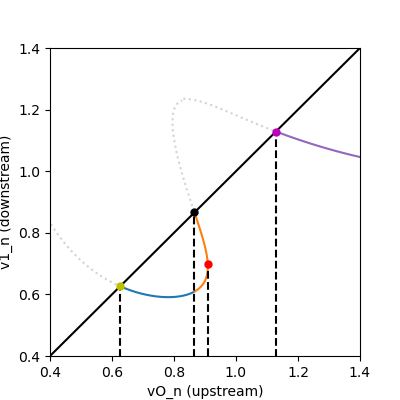

In [40]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(4, 4))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot([0, 2], [0, 2], color='k')

ax.plot(v0_n_span_A, v1_n_span_A, color='lightgray', linestyle=':')
ax.plot(v0_n_span_B, v1_n_span_B, color=cycle[0])
ax.plot(v0_n_span_C, v1_n_span_C, color=cycle[1])
ax.plot(v0_n_span_D, v1_n_span_D, color='lightgray', linestyle=':')
ax.plot(v0_n_span_E, v1_n_span_E, color='lightgray', linestyle=':')
ax.plot(v0_n_span_F, v1_n_span_F, color=cycle[4])

ax.plot([v0_s, v0_s], [0, v0_s], color='k', linestyle='--')
ax.plot([v0_i, v0_i], [0, v0_i], color='k', linestyle='--')
ax.plot([v0_f, v0_f], [0, v0_f], color='k', linestyle='--')

ax.plot([0.91, 0.91], [0.4, 0.70], color='k', linestyle='--')

ax.plot([v0_s], [v0_s], color='y', marker = "o", markersize=5)
ax.plot([v0_i], [v0_i], color='k', marker = "o", markersize=5)
ax.plot([v0_f], [v0_f], color='m', marker = "o", markersize=5)

ax.plot([0.91], [0.70], color='r', marker = "o", markersize=5)

ax.set_xlim([0.4, 1.4])
ax.set_ylim([0.4, 1.4])
ax.set_xlabel("vO_n (upstream)")
ax.set_ylabel("v1_n (downstream)")

plt.savefig("shock.pdf", dpi=300)

In [ ]:
plt.clf()